In [1]:
# This notebook computes the fitted ellipsoid to crack.
# This notebook can only be run after "3D reconstruction dev1.2 multi,ipynb"

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import csv
import os
import pathlib
import pickle
import subprocess
from stl import mesh
import stl
from numpy.linalg import norm, eig, inv, lstsq
from numpy import sin, cos, pi, arctan, sqrt
import ellipse as el
from scipy.optimize import minimize
from copy import deepcopy

# load custom modules
from image_proc_lib.file_util import *
from image_proc_lib.cv_util import *
from image_proc_lib.point_selector import *
from image_proc_lib.image_proc import *
from image_proc_lib.image_analyser2 import *

from geom_recon.utils import *
from geom_recon.view_manager import *
from geom_recon.plotting import *
from geom_recon.process_view_util import *
from geom_recon.scad_manager import *
from geom_recon.adjustment_cal import *
from geom_recon.ellipse import *
from geom_recon.ellipsoid_recon import *
from geom_recon.result_container import *

# just to shut up the stl library, otherwise, it prints too much...
import logging
logging.getLogger("stl").setLevel(logging.ERROR)
logging.getLogger(stl.__name__).setLevel(logging.ERROR) 

In [6]:
# Define import export stuff  

# define the file names from which the frame by frame tracking data
# exported from "continuous_run_dev2.ipynb" can be loaded. 
data_file_names = ['processed data 0/frame_descriptor_pickle_dump 0.pickle',\
                   'processed data 45/frame_descriptor_pickle_dump 45.pickle',\
                   'processed data 90/frame_descriptor_pickle_dump 90.pickle',\
                   'processed data 135/frame_descriptor_pickle_dump 135.pickle']

# define the file names from which the processing information
# exported from "continuous_run_dev2.ipynb" can be loaded. 
processing_info_file_names = ['processed data 0/processing information 0.txt',\
                              'processed data 45/processing information 45.txt', \
                              'processed data 90/processing information 90.txt',\
                              'processed data 135/processing information 135.txt']

# define the file names from which the calibratipn result from
# "3D reconstruction dev1.2 multi,ipynb" can be loaded
export_dir = 'multi_view_data'
adj_export_file_name = export_dir + '\\adjustment.pickle'
vm_export_file_name = export_dir + "\\" + "vm_dump" + ".pickle"

# define the number of views and the position of the views.
n_view = 4
view_labels = ['0', '45', '90', '135']
view_angles = [0, 45, 90, 135]

# this defines the range of the data that will be processed
min_frame_ind = 660
max_frame_ind = 950


In [7]:
# Extract the length scale from the processing information
# exported by "continuous_run_dev2.ipynb"
calib_scale_list = [] # in mm/pixel
for i in range(n_view):
    with open(processing_info_file_names[i], mode='r') as f:
        line = None
        for j in range(8):
            line = f.readline()
        calib_scale_list.append(float(line.split(' ')[2]))

calib_scale = np.mean(np.array(calib_scale_list))
calib_scale = calib_scale/1000
print('calib scale from different views (mm/pixel):')
print_np(calib_scale_list, sf=4)
print('calib_scale: ' + str(calib_scale) + ' m/pixel')

calib scale from different views (mm/pixel):
1e-1*
[0.407 0.414 0.414 0.412]
calib_scale: 4.116561303462809e-05 m/pixel


In [8]:
# Preparation. Load various information
# Load all the frame descriptor data exported from img proc
all_data = []
for i in range(n_view):
    curr_data = None
    with open(data_file_names[i], mode='rb') as f:
        curr_data = pickle.load(f)
    all_data.append(curr_data)

# Load the vm from calibration
vm_list = []
with open(vm_export_file_name, mode='rb') as f:
    vm_list = pickle.load(f)
adj = None
with open(adj_export_file_name, mode='rb') as f:
    adj = pickle.load(f)
    
# get a rotation matrix that rotates points about the y-axis
# give the angle in degree
def get_rot_mat_p_y(angle):
    angle = angle/180*np.pi
    row1 = [cos(angle), 0, sin(angle)]
    row2 = [0, 1, 0]
    row3 = [-sin(angle), 0, cos(angle)]
    return np.array([row1, row2, row3])

# Prepare the C_list to define the angle of projection
# C_list[i] contains two column vectors that represents the +x and +y direction of the projection
# plane in 3D world frame coordinates.
# For more inforamtion, see "reconstructing ellipsoids from projections, William C. Karl Nov 10 1993"
C0 = np.transpose([[1, 0, 0], [0, 1, 0]])
C_list = []
for i in range(n_view):
    rot_mat_p = get_rot_mat_p_y(view_angles[i])
    C_angle = np.matmul(rot_mat_p, C0)
    C_list.append(C_angle)

In [9]:
# define relevant functions
def retrieve_frame_descriptors(all_data, frame_of_interest):
    frame_descriptors = []
    for i in range(n_view):
        found = False
        for element in all_data[i]:
            if element.get_frame_ind_abs() == frame_of_interest:
                frame_descriptors.append(element)
                found = True
                break
        if not found:
            print("Error, frame " + str(frame_of_interest) + " for view " + str(i) + " not found!")
            break
    return frame_descriptors

def center_contour(cnt):
    cnt = filter_twice(cnt)
    e2 = lsq_ellipse(cnt)
    return cnt - np.array([e2.x_offset, e2.y_offset])

def filter_using_hull(data, reduction_factor=0.8, visualize=False):
    # shift the data so it becomes zero centered
    x_cent = np.mean(data[:, 0])
    y_cent = np.mean(data[:, 1])
    data_cent = data - np.array([x_cent, y_cent])
    data_reduced = data_cent*reduction_factor
    # now filter the points. Remove a point if it lies inside the reduced hull
    reduced_hull = ConvexHull(data_reduced)
    A = reduced_hull.equations[:, 0:2]
    b = reduced_hull.equations[:, 2]
    filtered_pts = []
    for pt in data_cent:
        if np.any((A@pt+b)>0):
            filtered_pts.append(pt)
    filtered_pts = np.array(filtered_pts)
    if visualize:
        plt.plot(data_cent[:, 0], data_cent[:, 1])
        plt.plot(data_reduced[:, 0], data_reduced[:, 1])
        plt.scatter(filtered_pts[:, 0], filtered_pts[:, 1])
#     if len(filtered_pts) < 10:
#         print('Too restrictive at reduction factor = ' + str(reduction_factor))
#         return filter_using_hull(data, (1 + reduction_factor)/2)
    return filtered_pts + np.array([x_cent, y_cent])

def filter_twice(data, reduction_factor=0.8, disp=False):
    filtered_data = filter_using_hull(data, reduction_factor)
    reg = el.LsqEllipse().fit(filtered_data)
    c = reg.coefficients
    x = filtered_data[:, 0]
    y = filtered_data[:, 1]
    # [a,b,c,d,f,g] corresponding to ax**2 + bxy + cy**2 + dx + fy + g
    res = c[0]*x*x + c[1]*x*y + c[2]*y*y + c[3]*x + c[4]*y + c[5]
    res = np.abs(res)
    res_s = np.sort(res)
    thresh = res_s[int(len(res)*0.9)]
    thresh = np.median(res)
    # thresh = 2*np.mean(res)
    if disp:
        plt.plot(res)
        plt.plot([1, len(res)], [thresh, thresh])
        plt.show()
    filtered_data2 = []
    for i in range(len(filtered_data)):
        if res[i] < thresh:
            filtered_data2.append(filtered_data[i])
    filtered_data2 = np.array(filtered_data2)
    return filtered_data2

def lsq_ellipse(data):
    reg = el.LsqEllipse().fit(data)
    c = reg.coefficients
    cent = reg.as_parameters()[0]
    corrected_f = c[-1] - c[0]*cent[0]**2 - c[2]*cent[1]**2 - c[1]*cent[0]*cent[1]
    mat = np.array([[c[0], c[1]/2], [c[1]/2, c[2]]])/corrected_f
    if mat[0, 0] < 0:
        mat = -mat
    me2 = MatEllipse(mat)
    me2.offset(cent[0], cent[1])
    return me2

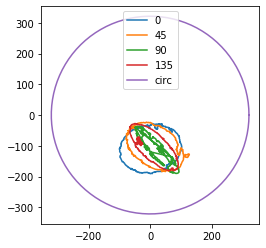

In [10]:
# Some plotting to check that the data is alright
# The detected contours from each of the views are plotted after they 
# are rotated up right and aligned. 
curr_frame = (min_frame_ind + max_frame_ind) //2
descriptors = retrieve_frame_descriptors(all_data, curr_frame)
p_descriptors = [process_view_all_pts(descriptors[i], vm_list[i]) for i in range(n_view)]
plot_processed_view(p_descriptors, view_labels)

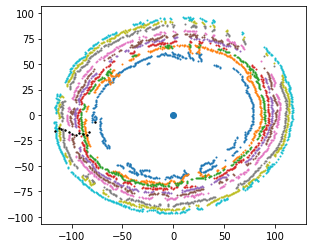

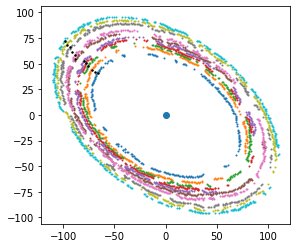

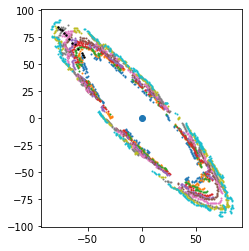

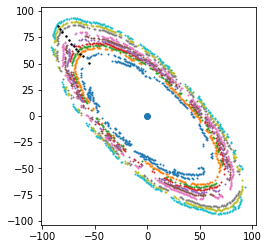

reference axis:  [ 0.12121041 -0.66085878  0.74065762]


In [11]:
# Compute the ref_ax based on the long axis of the ellipses in different projection views
# The ref ax is the expected short axis of the 3D ellipsoid.

# Basic idea: 
# The long axis of the ellipse in each of the views should lie in the circular
# crack plane (This can be shown by considering the projection of the ellipsoid).
# In 3D, the short axis of the the ellipsoid should be perpendicular to the long axis
# in the ellipse in each of the views. Note that the long axis in the ellipse can be 
# transformed to 3D using the C_list[i] matrix.
# The crack plane of the crack should not vary, so the short axis direction of the ellipsoid should
# remain a constant through time, and it should be perpendicular to all the long axes in the ellipses
# in all the views at all time. 
# This forms the basis of the fitting.

disp = True
plane_vec = None
ref_ax_data_step = 25
ref_ax_plot_n = 10
ref_ax_plot_step = (max_frame_ind - min_frame_ind)/ref_ax_plot_n
for data_ind in range(n_view):
    pt_list = []
    e_vec_list = []
    plot_control = min_frame_ind
    for frame_ind in range(min_frame_ind, max_frame_ind, ref_ax_data_step):
        descriptors = retrieve_frame_descriptors(all_data, frame_ind)
        cnt = process_view_all_pts(descriptors[data_ind], vm_list[data_ind]).processed_cnt
        cnt = center_contour(cnt)
        e2 = lsq_ellipse(filter_twice(cnt))
        e_val, e_vecs = eig(e2.mat)
        pt = np.array([[1], [0]])
        if e_val[1] < e_val[0]:
            e_vec_list.append(np.transpose(e_vecs[:, 1]))
            pt = np.array([[0], [1]])
        else:
            e_vec_list.append(np.transpose(e_vecs[:, 0]))
        pt[0] = pt[0]/np.sqrt(e_val)[0]
        pt[1] = pt[1]/np.sqrt(e_val)[1]
        pt_rot = e_vecs@pt
        pt_list.append(np.transpose(pt_rot)[0])
        if disp:
            if frame_ind >= plot_control:
                plot_control = plot_control + ref_ax_plot_step
                plt.scatter(cnt[:, 0], cnt[:, 1], s=1)
            plt.scatter(pt_rot[0], pt_rot[1], s=2, color=(0, 0, 0))
    new_vec = C_list[data_ind]@np.transpose(e_vec_list)
    if plane_vec is None:
        plane_vec = new_vec
    else:
        plane_vec = np.append(plane_vec, new_vec, axis=1)
    if disp:
        plt.scatter([0], [0])
        plt.gca().set_aspect('equal', 'box')
        plt.show()

a_full = np.transpose(plane_vec)
a_l = a_full[:, 0:2]
a_r = -a_full[:, 2]
ax12 = lstsq(a_l, a_r, rcond=None)[0]
ref_ax = np.array([ax12[0], ax12[1], 1])
if ref_ax[0] < 0:
    ref_ax = -ref_ax
ref_ax = ref_ax / norm(ref_ax)
print("reference axis: ", ref_ax)

In [12]:
def get_short_axis(e3):
    mat = e3.mat
    e_val, e_vecs = eig(mat)
    res = None
    for i in range(3):
        if e_val[i] == max(e_val):
            res = np.transpose(e_vecs[:, i])
            break
    if res[0] < 0:
        res = - res
    return res

def compute_residual(n_view, c_cnts, C_list, mat):
    res = 0
    for i in range(n_view):
        cnt = c_cnts[i]
        e2 = MatEllipsoid(mat).project(C_list[i])
        e2_mat = e2.mat
        right_m = np.matmul(e2_mat, np.transpose(cnt))
        l = len(cnt)
        for i in range(l):
            res = res + 1000/l*(np.dot(cnt[i], right_m[:, i]) - 1)**2
    return res

def compute_residual_vec(n_view, c_cnts, C_list, vec):
    return compute_residual(n_view, c_cnts, C_list, MatEllipsoid.vec2mat(vec).mat)

def compute_residual_vec2(n_view, c_cnts, C_list, vec, ref_axis):
    pt_res = compute_residual(n_view, c_cnts, C_list, MatEllipsoid.vec2mat(vec).mat)
    if ref_axis is None:
        return pt_res
    else:
        # penalize for the rotation of the axis
        curr_ax = get_short_axis(MatEllipsoid.vec2mat(vec))
        angle = np.arccos(np.dot(curr_ax, ref_axis))
        # Note that we can constrain the short axis to the ref-ax computed above
        # by penalizing for the deviation from this axis in the fitting.
        # This penalty can be turned on or off.
        return pt_res + 0*100000*angle**2

In [13]:
def compuate_e3_center(p_descriptors, C_list):
    cent_list = []
    n_view = len(p_descriptors)
    for i in range(n_view):
        e2 = lsq_ellipse(p_descriptors[i].processed_cnt)
        cent_list.append([e2.x_offset, e2.y_offset])
    lhs = np.transpose(C_list[0])
    for i in range(1, n_view):
        lhs = np.append(lhs, np.transpose(C_list[i]), axis=0)
    rhs = np.array(cent_list).flatten()
    e3_center = lstsq(lhs, rhs, rcond=None)[0]
    return e3_center
    
# Used for ellipsoid fitting in using the method in 
# "reconstructing ellipsoids from projections, William C. Karl Nov 10 1993"
class EllipsoidFit(object):
    def __init__(self, p_descriptors, C_list, verbose=False):
        self.p_descriptors = p_descriptors
        self.C_list = C_list
        self.m_ellipse_list = [lsq_ellipse(filter_twice(d.processed_cnt)) for d in p_descriptors]
        self.e3_r = reconstruct_ellipsoid(self.m_ellipse_list, C_list, verbose=verbose)
    
    def plot_processed_result(self):
        ellipses = []
        for i in range(len(C_list)):
            projected = self.e3_r.project(self.C_list[i])
            projected.offset(self.m_ellipse_list[i].x_offset, self.m_ellipse_list[i].y_offset)
            ellipses.append(projected)
        plot_ellipse_fit_single_plot(ellipses, self.p_descriptors)
        plt.show()
    
    def plot_ellipse_fit(self):
        plot_ellipse_fit_single_plot(self.m_ellipse_list, self.p_descriptors)
        plt.show()
    
    def get_rad(self):
        e_vals = np.sort(eig(self.e3_r.mat)[0])
        rad = 1/np.sqrt(e_vals)
        return rad

# Used for direct least sqaure ellipsoid fitting
# The distance between the contour points and the projection of the 3D
# fitted ellipsoid is minimized.
# It is possible to constrain the short axis of the ellipsoid as well.
# (see comment in "compute_residual_vec2")
class EllipsoidFit2(object):
    def __init__(self, p_descriptors, C_list, ref_ax=None, tol=1, verbose=False):
        # save everything
        self.p_descriptors = deepcopy(p_descriptors)
        self.C_list = C_list
        # constuct the centered version of everything
        self.centered_contours = [center_contour(p.processed_cnt) for p in p_descriptors]
        self.p_cent = []
        for i in range(len(C_list)):
            temp_p = p_descriptors[i]
            temp_p.processed_cnt = deepcopy(self.centered_contours[i])
            self.p_cent.append(temp_p)
        # use the previous fitting to generate a guess
        fit_to_ellipses = EllipsoidFit(p_descriptors, C_list, verbose=False)
        x0 = fit_to_ellipses.e3_r.to_vec()
        # define the objective function. The 3*3 PSD mat is represented as a vector to avoid redundancy
        obj_func = lambda vec: compute_residual_vec2(len(self.C_list), 
                                                    self.centered_contours, 
                                                    self.C_list, 
                                                    vec,
                                                    ref_ax)
        # run the fitting using scipy.optimize.minimize (with a generic algorithm)
        fitted_vec = minimize(obj_func, x0, tol=tol)
        self.e3_r = MatEllipsoid.vec2mat(fitted_vec.x)
        self.e3_r.center = compuate_e3_center(self.p_descriptors, C_list)
        
    
    def plot_processed_result(self):
        ellipses = []
        for i in range(len(C_list)):
            projected = self.e3_r.project(self.C_list[i])
            ellipses.append(projected)
        plot_ellipse_fit_single_plot(ellipses, self.p_cent)
        plt.show()
    
    def get_rad(self):
        e_vals = np.sort(eig(self.e3_r.mat)[0])
        rad = 1/np.sqrt(e_vals)
        return rad

processed_result: 660


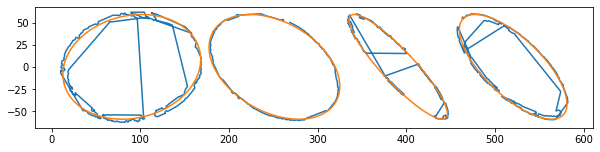

processed_result: 666


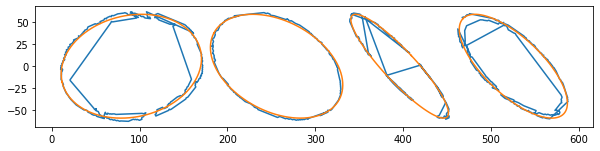

processed_result: 672


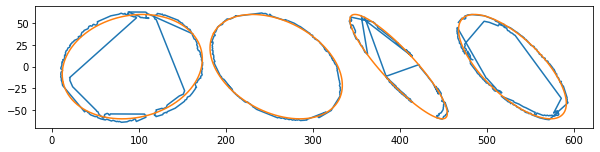

processed_result: 678


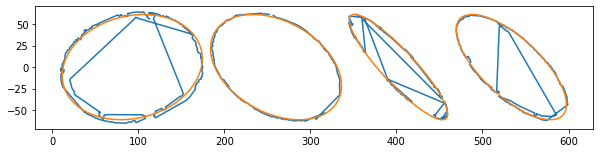

processed_result: 684


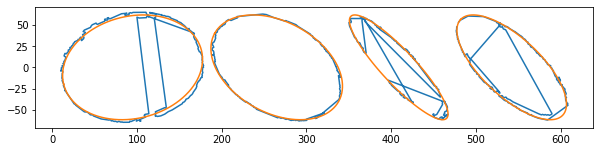

processed_result: 690


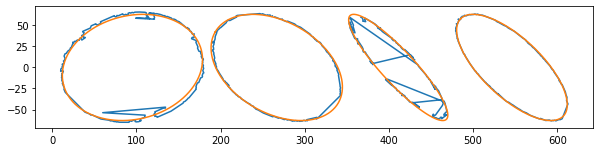

processed_result: 696


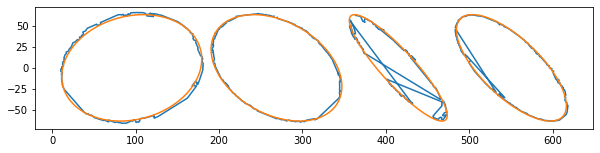

processed_result: 702


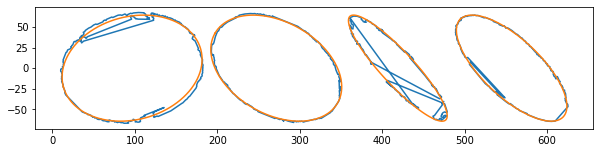

processed_result: 708


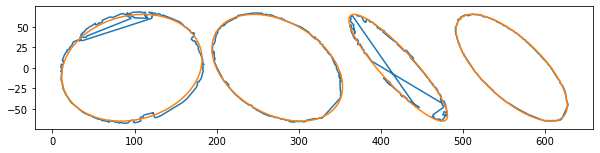

processed_result: 714


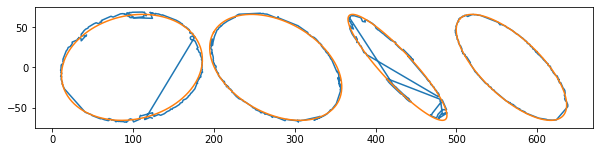

processed_result: 720


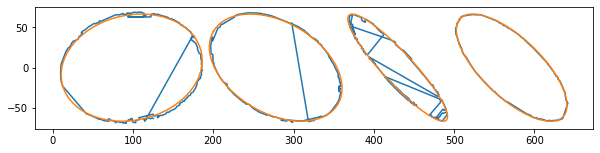

processed_result: 726


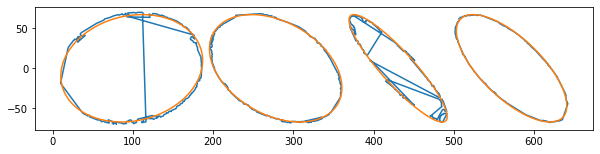

processed_result: 732


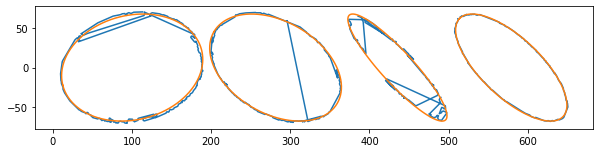

processed_result: 738


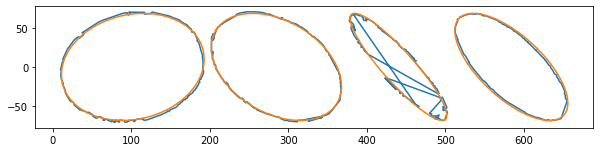

processed_result: 744


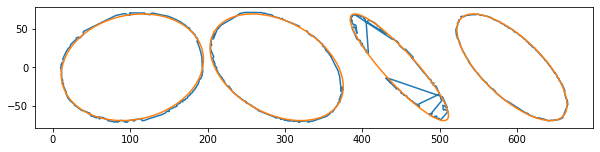

processed_result: 750


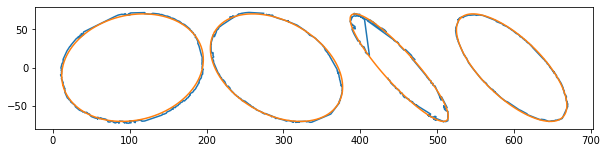

processed_result: 756


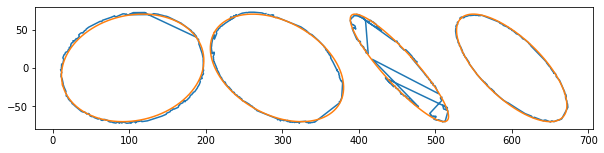

processed_result: 762


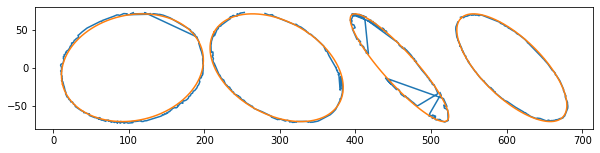

processed_result: 768


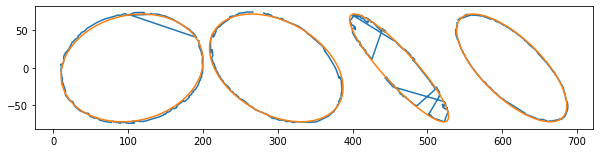

processed_result: 774


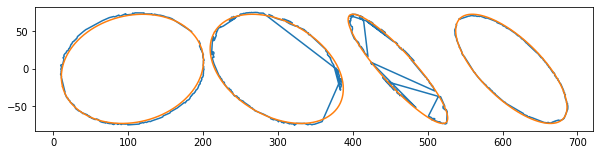

processed_result: 780


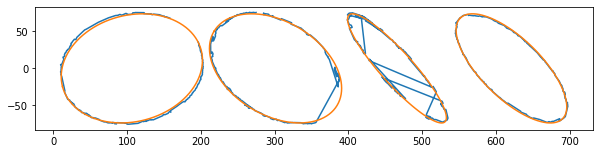

processed_result: 786


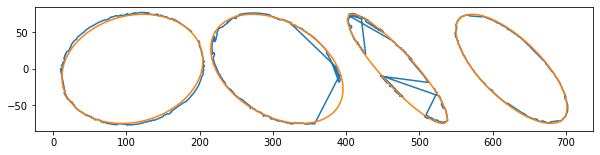

processed_result: 792


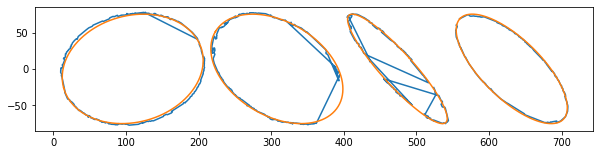

processed_result: 798


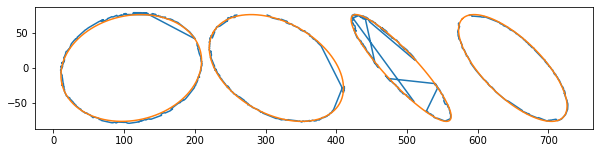

processed_result: 804


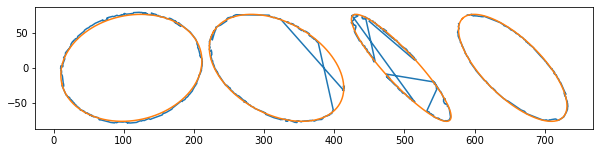

processed_result: 810


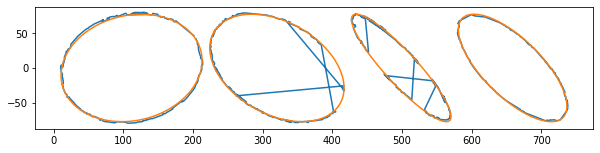

processed_result: 816


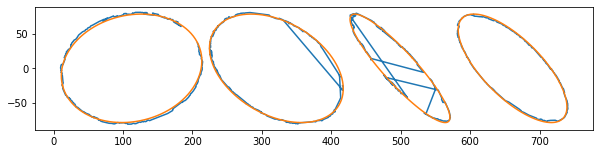

processed_result: 822


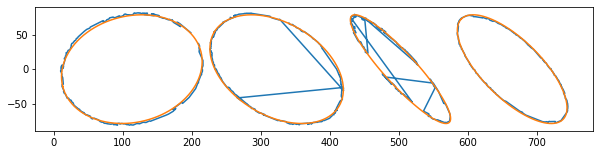

processed_result: 828


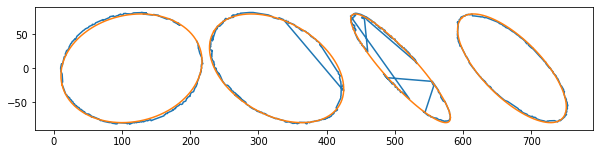

processed_result: 834


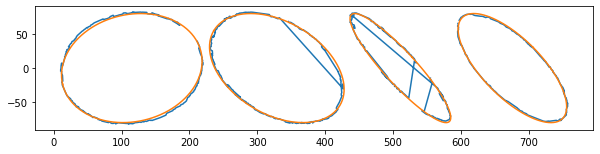

processed_result: 840


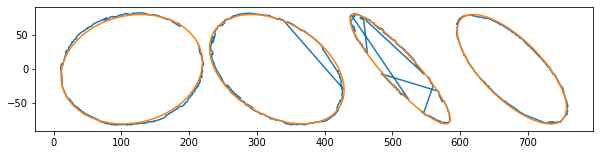

processed_result: 846


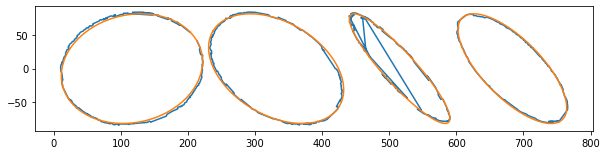

processed_result: 852


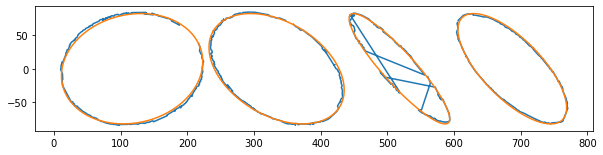

processed_result: 858


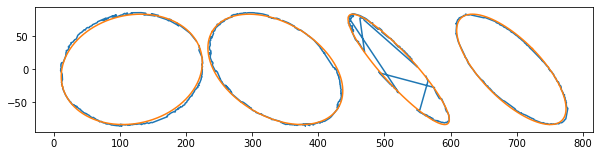

processed_result: 864


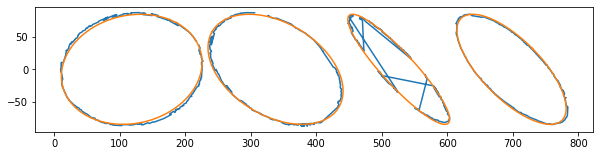

processed_result: 870


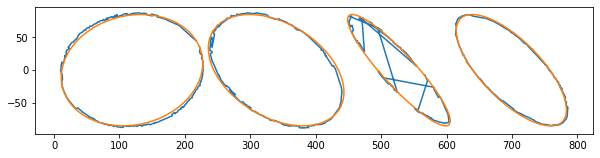

processed_result: 876


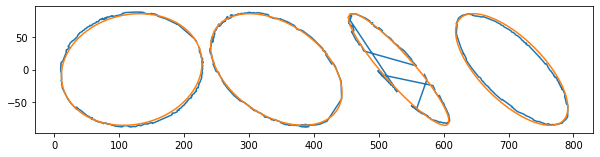

processed_result: 882


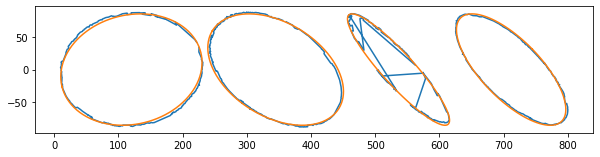

processed_result: 888


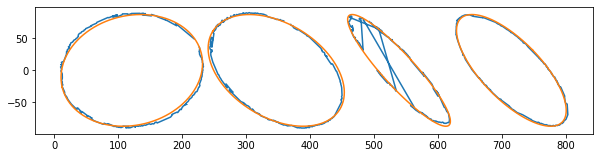

processed_result: 894


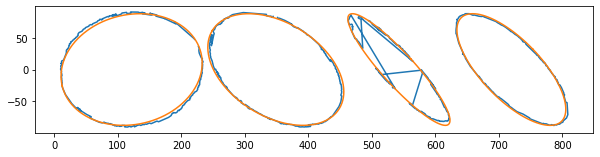

processed_result: 900


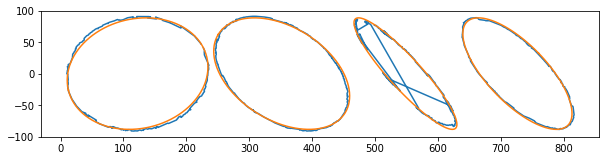

processed_result: 906


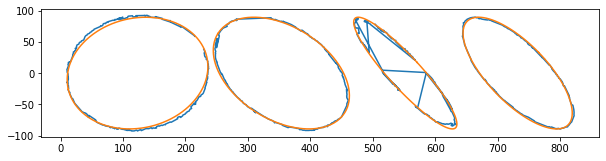

processed_result: 912


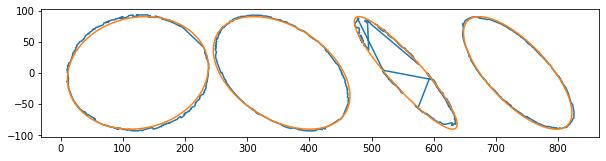

processed_result: 918


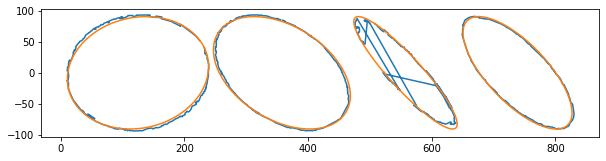

processed_result: 924


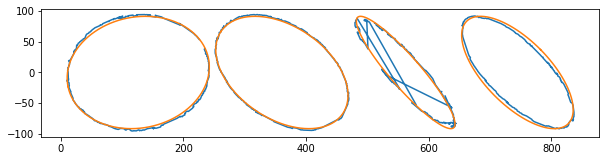

processed_result: 930


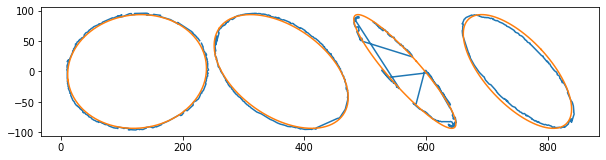

processed_result: 936


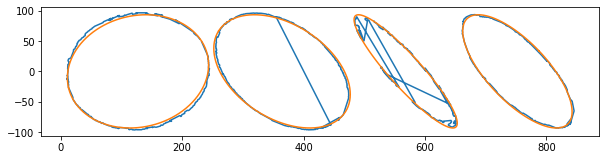

processed_result: 942


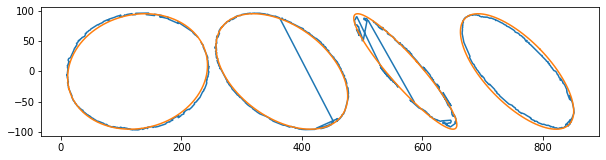

processed_result: 948


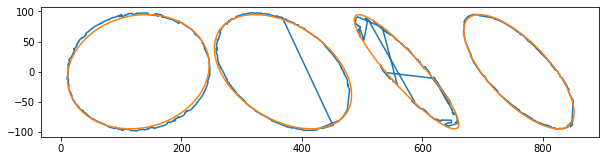

In [14]:
# Conduct the fitting.
ellipsoid_fit_step = 2 # sets the sub-sampling as fitting all frames will typically take too long
frame_list2 = [i for i in range(min_frame_ind, max_frame_ind, ellipsoid_fit_step)]
frame_list = []
plot_step = 3
rad_list = []
ellipse_list = []

for ind in frame_list2:
    print(ind, end='\r')
    descriptors = retrieve_frame_descriptors(all_data, ind)
    p_descriptors = [process_view_all_pts(descriptors[i], vm_list[i]) for i in range(n_view)]
    my_fit = EllipsoidFit2(p_descriptors, C_list, verbose=False, ref_ax=ref_ax)
    if ind % plot_step == 0:
        print("processed_result: " + str(ind))
        # plots the (filtered) contour points against the projection of the fitted ellipsoid.
        my_fit.plot_processed_result()
        print("============================")
    if np.linalg.det(my_fit.e3_r.mat) > 0:
        ellipse_list.append(my_fit.e3_r)
        rad_list.append(my_fit.get_rad())
        frame_list.append(ind)
rad_list = np.transpose(rad_list)

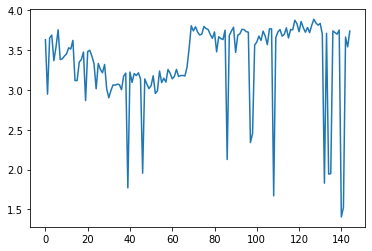

In [15]:
# Compute the angle deviation between the short axes of the ellipsoids
# and the reference axis (ref_ax).
# Ideally, the deviation should be small.
# This plot can be used to evaluate data quality.
angle_list = []
for curr_e in ellipse_list:
    cos_val = np.dot(ref_ax, get_short_axis(curr_e))
    if cos_val > 1:
        cos_val = 1
    if cos_val < -1:
        cos_val = -1
    angle = np.arccos(cos_val)
    angle_list.append(angle*180/np.pi)
plt.plot(angle_list)
#plt.ylim([0, 10])
plt.show()

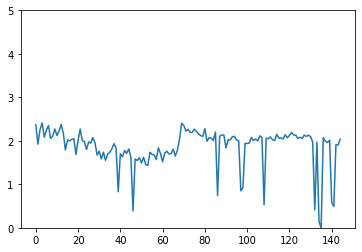

In [16]:
# Compute the angle deviation between the short axes of the ellipsoids
# and the short axis of one of the ellipsoids.
# Ideally, the deviation should be small.
# This plot can be used to evaluate data quality if ref_ax determination is inaccurate.
angle_list = []
for curr_e in ellipse_list:
    cos_val = np.dot(get_short_axis(ellipse_list[-10]), get_short_axis(curr_e))
    if cos_val > 1:
        cos_val = 1
    if cos_val < -1:
        cos_val = -1
    angle = np.arccos(cos_val)
    angle_list.append(angle*180/np.pi)
plt.plot(angle_list)
plt.ylim([0, 5])
plt.show()

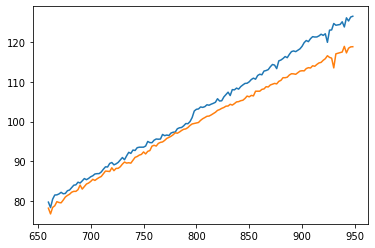

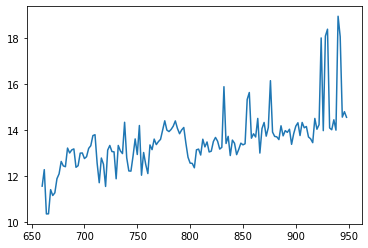

In [17]:
# plot the three principle radii of the fitted ellipsoid.
plt.plot(frame_list, rad_list[0])
plt.plot(frame_list, rad_list[1])
plt.show()
plt.plot(frame_list, rad_list[2])
#plt.ylim([0, 20])
plt.show()

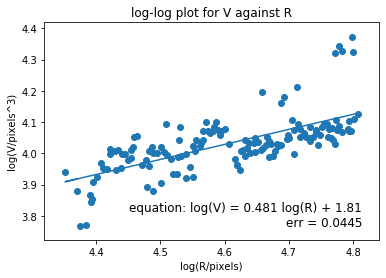

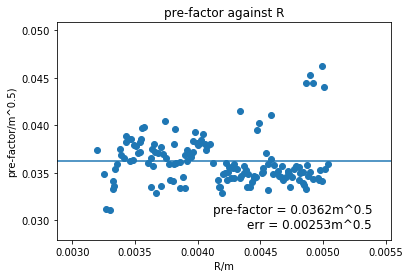

In [18]:
# Plot volume V against radius R.
# beta = 4*pi/3 * sqrt(l) can be computed. (l is the elasto-fracture length scale)
# Note that only a rough value of beta is computed because outlier points
# are not removed here.

# Compute the radius of the crack plane
# Instead using the arithmatic mean, the geometric mean is more significant
mean_list = np.sqrt(rad_list[0] * rad_list[1]) 
vol = 4/3*pi*rad_list[0] * rad_list[1] * rad_list[2]

# plot range
lower_ind = 0
upper_ind = -1

# make log-log plot
log_r = np.log(mean_list[lower_ind:upper_ind])
log_vol = np.log(vol[lower_ind:upper_ind]) - 2*log_r
slope, intercept, r_value, p_value, std_err = stats.linregress(log_r, log_vol)
estimated_y = log_r*slope + intercept
plt.scatter(log_r, log_vol)
plt.plot(log_r, estimated_y)
ax = plt.gca()
plt.text(0.95, 0.05, 
         "equation: log(V) = " + f'{slope:.3}' + \
         ' log(R) + ' + f'{intercept:.3}' + \
         '\nerr = ' + f'{std_err:.3}',
         fontsize=12,
         horizontalalignment='right', 
         verticalalignment='bottom', 
         transform=ax.transAxes)
plt.title("log-log plot for V against R")
plt.xlabel("log(R/pixels)")
plt.ylabel("log(V/pixels^3)")
plt.show()

# now, compute the prefactor assuming that the exponent is 2.5
vol_c_u = vol[lower_ind:upper_ind] * calib_scale**3
r_c_u = mean_list[lower_ind:upper_ind] * calib_scale
log_r_c_u = np.log(r_c_u)
log_vol_c_u = np.log(vol_c_u)
log_pre_factor_c_u = log_vol_c_u - 2.5*log_r_c_u
pre_factor_c_u = np.exp(log_pre_factor_c_u)
p_std = np.std(pre_factor_c_u)
p_mean = np.mean(pre_factor_c_u)

plt.scatter(r_c_u, pre_factor_c_u)
plt.plot([min(r_c_u)*0.9, max(r_c_u)*1.1], [p_mean, p_mean])
plt.title("pre-factor against R")
plt.xlabel("R/m")
plt.ylabel("pre-factor/m^0.5)")
plt.xlim([min(r_c_u)*0.9, max(r_c_u)*1.1])
plt.ylim([min(pre_factor_c_u)*0.9, max(pre_factor_c_u)*1.1])
plt.text(0.95, 0.05, 
         "pre-factor = " + f'{p_mean:.3}' + 'm^0.5'\
         '\nerr = ' + f'{p_std:.3}' + 'm^0.5',
         fontsize=12,
         horizontalalignment='right', 
         verticalalignment='bottom', 
         transform=ax.transAxes)
plt.show()

In [19]:
# Data export

# Export the fitted ellipsoid to csv
header = ['frame_ind_abs', 
          'e3_vec[0]', 'e3_vec[1]', 'e3_vec[2]', 'e3_vec[3]', 'e3_vec[4]', 'e3_vec[5]',
          'e3_cent[0]', 'e3_cent[1]', 'e3_cent[2]']
all_rows = []
for i in range(len(frame_list)):
    row = np.array(frame_list[i])
    e3 = ellipse_list[i]
    row = np.append(row, e3.to_vec())
    cent = e3.center
    row = np.append(row, e3.center)
    all_rows.append(row)
all_rows = np.array(all_rows)

# make the directory that contains the data
rel_dir_name = "3D result summary"
if exist_directory(rel_dir_name):
    print("\"" + rel_dir_name + "\" already exists.")
else:
    os.mkdir(full_path(rel_dir_name))
    print("directory \"" + rel_dir_name + "\" is made")

export_to_csv(rel_dir_name + "\\" + "ellipsoid fit data" + ".csv", 
              all_rows, 
              header)

# pickle dump everything
# define a container
class EllipsoidFitSummary(object):
    def __init__(self, frame_list, ellipsoid_list, ref_ax):
        self.frame_list = frame_list
        self.ellipsoid_list = ellipsoid_list
        self.ref_ax = ref_ax


f = open_file_w_with_check(rel_dir_name + "\\" + "ellipsoid fit data" + ".pickle",
                           mode='wb')
result = EllipsoidFitSummary(frame_list, ellipse_list, ref_ax)
if not (f is None):
    pickle.dump(result, f)
    f.close()

directory "3D result summary" is made
